# Генетический алгоритм. Практическая реализация
## Выполнила: Воляница Елизавета Петровна, группа 4410

### Часть 1. Реализация генетического алгоритма на примере задачи о рюкзаке

In [1]:
# Импорт необходимых библиотек

from random import choices, randint, randrange, random
from typing import List, Optional, Callable, Tuple
from collections import namedtuple
from functools import partial
import time

In [2]:
# Объявление объектов и функций, с которыми будем работать

Genome = List[int] # Геном - закодированное представление рюкзака
Population = List[Genome] # Популяция - набор геномов
FitnessFunc = Callable[[Genome], int] # Проверка полученного решения
PopulateFunc = Callable[[], Population] # Генерация популяции. Шаг инициализации
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome, Genome]] # Функция селекции
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]] # Функция скрещивания
MutationFunc = Callable[[Genome], Genome] # Функция мутации

# Объект вещи, с которым будем работать

Thing = namedtuple('Thing', ['name', 'value', 'weight'])

In [3]:
# Генерация случайного генома определенной длины

def generate_genome(length: int) -> Genome:
    return choices([0, 1], k=length)

In [4]:
# Генерация популяции

def generate_population(size: int, genome_length: int) -> Population:
    return [generate_genome(genome_length) for _ in range(size)]

In [5]:
# Проверка ценности набора вещей. Проверка полученного решения

def fitness(genome: Genome, things: [Thing], weight_limit: int) -> int:
    if len(genome) != len(things):
        raise ValueError("Геном и список вещей должны быть одной длины")
        
    weight = 0
    value = 0
    
    for i, thing in enumerate(things):
        if genome[i] == 1:
            weight += thing.weight
            value += thing.value
            
            if weight > weight_limit:
                return 0
    return value

In [6]:
# Отбор лучших вариантов среди популяции

def selection_pair(population: Population, fitness_func: FitnessFunc) -> Population:
    return choices(
        population=population,
        weights=[fitness_func(gene) for gene in population],
        k=2
    )

In [7]:
# Случайное скрещивание геномов

def single_point_crossover(a: Genome, b: Genome) -> Tuple[Genome, Genome]:
    if len(a) != len(b):
        raise ValueError("Геномы должны быть одной длины")

    length = len(a)
    if length < 2:
        return a, b

    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

In [8]:
# Случайная мутация геномов

def mutation(genome: Genome, num: int = 1, probability: float = 0.5) -> Genome:
    for _ in range(num):
        index = randrange(len(genome))
        genome[index] = genome[index] if random() > probability else abs(genome[index] - 1)
    return genome

In [9]:
# Объединение всех методов в один алгоритм

def run_evolution(
    population_func: PopulateFunc,
    fitness_func: FitnessFunc,
    fitness_limit: int,
    selection_func: SelectionFunc = selection_pair, 
    crossover_func: CrossoverFunc = single_point_crossover,
    mutation_func: MutationFunc = mutation,
    generation_limit: int = 100
) -> Tuple[Population, int]:
    # Инициализация
    population = population_func()
    
    # Повторяется до ограничения на количество поколений
    for i in range(generation_limit):
        # Сортируется, чтоб лучшие популции были в начале
        population = sorted(population, key=lambda genome: fitness_func(genome), reverse=True)
        
        # Если качество популяции лучше, чем заданное, то алгоритм завершается
        if fitness_func(population[0]) >= fitness_limit:
            return population, i

        # В новое поколение передаем две лучшие популции
        next_generation = population[0:2]

        for j in range(int(len(population) / 2) - 1):
            parents = selection_func(population, fitness_func)
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            next_generation += [offspring_a, offspring_b]

        population = next_generation

    return population, i

### Добавляем утилиты для вывода ответов и работой с объектами

In [10]:
def to_string(things: [Thing]):
    return f"[{', '.join([t.name for t in things])}]"


def value(things: [Thing]):
    return sum([t.value for t in things])


def weight(things: [Thing]):
    return sum([p.weight for p in things])


def print_stats(things: [Thing]):
    print(f"Лучший результат: {to_string(things)}")
    print(f"Ценность: {value(things)}")
    print(f"Вес: {weight(things)}")

def genome_to_list(genome: Genome, things: [Thing]) -> [Thing]:
    result = []
    for i, thing in enumerate(things):
        if genome[i] == 1:
            result += [thing]
    
    return result

### Проверка алгоритма на маленьком количестве объектов

In [11]:
# Список объектов

easy_example = [
    Thing('Ноутбук', 500, 2200),
    Thing('Наушники', 150, 160),
    Thing('Чашка', 60, 350),
    Thing('Записная книжка', 40, 333),
    Thing('Бутылка воды', 30, 192),
]

In [12]:
population, generations = run_evolution(
    population_func=partial(
        generate_population, size=15, genome_length=len(easy_example)
    ),
    fitness_func=partial(
        fitness, things=easy_example, weight_limit=3000
    ),
    fitness_limit=740,
    generation_limit=100
)

In [13]:
# Вывод результатов
results = genome_to_list(population[0], easy_example)

print(f"Количество поколений: {generations}")
print_stats(results)

Количество поколений: 15
Лучший результат: [Ноутбук, Наушники, Чашка, Бутылка воды]
Ценность: 740
Вес: 2902


### Часть 2. Сравнение различных алгоритмов

### Перебор

In [14]:
def bruteforce(things: [Thing], weight_limit: int) -> Tuple[Population, int]:
    if len(things) == 0:
        return 0, []

    max_value = 0
    max_valued_packed = []
    for i, thing in enumerate(things):
        if thing.weight > weight_limit:
            continue

        value, packed = bruteforce(things[i + 1:], weight_limit - thing.weight)
        if value + thing.value >= max_value:
            max_value = value + thing.value
            max_valued_packed = [thing] + packed

    return max_value, max_valued_packed

### Жадный алгоритм

In [15]:
def gredy(things: [Thing], weight_limit: int) -> Tuple[Population, int]:
    if len(things) == 0:
        return 0, []

    total_weight = 0
    max_valued_packed = []
    things = sorted(things, key=lambda thing: thing.value, reverse=True)
    for i, thing in enumerate(things):
        if thing.weight > weight_limit:
             continue

        if total_weight + thing.weight <= weight_limit:
            total_weight += thing.weight
            max_valued_packed += [thing]

    return max_valued_packed

#### Проверка на большем количестве объектов

In [16]:
hard_example = [
    Thing('1', 5, 25),
    Thing('2', 10, 38),
    Thing('3', 15, 80),
    Thing('4', 500, 200),
    Thing('5', 100, 23),
    Thing('6', 120, 365),
    Thing('7', 340, 570),
    Thing('8', 480, 340),
    Thing('9', 84, 170),
    Thing('10', 12, 20),
    Thing('11', 28, 1400),
    Thing('12', 450, 700),
    Thing('13', 512, 2600),
    Thing('14', 100, 23),
    Thing('15', 120, 365),
    Thing('16', 340, 570),
    Thing('17', 480, 340),
    Thing('18', 84, 170),
    Thing('19', 12, 20),
    Thing('20', 28, 1400),
    Thing('21', 450, 700),
    Thing('22', 512, 2600),
    Thing('23', 90, 1800),
    Thing('24', 560, 2900),
    Thing('25', 256, 256),
    Thing('26', 124, 340),
    Thing('27', 8, 2)
]

In [17]:
# Перебор

start_bruteforce = time.time()
population_bruteforce = bruteforce(
    things = hard_example,
    weight_limit=4000
)
end_bruteforce = time.time()

print_stats(population_bruteforce[1])
print(f"Время выполнения: {end_bruteforce - start_bruteforce}")

Лучший результат: [1, 2, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19, 21, 25, 27]
Ценность: 3627
Вес: 3997
Время выполнения: 6.518315076828003


In [18]:
# Жадный алгоритм

start_gredy = time.time()
population_gredy = gredy(
    things = hard_example,
    weight_limit=4000
)
end_gredy = time.time()

print_stats(population_gredy)
print(f"Время выполнения: {end_gredy - start_gredy}")

Лучший результат: [24, 4, 8, 17, 5, 14, 9, 27]
Ценность: 2312
Вес: 3998
Время выполнения: 0.00011301040649414062


In [50]:
# Генетический алгоритм

# Задаем максимальное количество поколений
generation_limit = 500

start_evolution = time.time()
population, generations = run_evolution(
    population_func=partial(
        generate_population, size=15, genome_length=len(hard_example)
    ),
    fitness_func=partial(
        fitness, things=hard_example, weight_limit=4000
    ),
    fitness_limit=population_bruteforce[0],
    generation_limit=generation_limit
)
end_evolution = time.time()


results = genome_to_list(population[0], hard_example)
if generations == generation_limit:
    print("Для нахождения оптимального решения перезапустите ячейку либо увеличьте количество поколений")
else:
    print("Найдено лучшее решение")
print_stats(results)
print(f"Время выполнения: {end_evolution - start_evolution}")

Найдено лучшее решение
Лучший результат: [1, 2, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19, 21, 25, 27]
Ценность: 3627
Вес: 3997
Время выполнения: 0.26531100273132324


##### Вывод
Как мы видим, генетический алгоритм - это самый оптимальный алгоритм для решения данной оптимизационной задачи. Он превосходит жадный алгоритм по качеству результата, а алгоритм перебора по времени выполнения. Однако, основная проблема генетического алгоритма заключается в случайности начальной инициализации - если выбраны не оптимальные или не близкие к оптимальным значения, то алгоритм может найти лишь локальный максимум. 

### Часть 3. Анализ точности алгоритма и времени выполнения на большом количестве данных

Проверка точности и времени выполнения будет проведена в условиях полной вместимости рюкзака. Идеальное решение должно помещать в себя все предложенные объекты. Также, для визуализации эффективности генетического алгоритма будет проводиться сравнение с алгоритмом перебора. Жадный алгоритм не рассматриваем, так как в таких условиях он будет лучшим выбором. 

In [20]:
full_weight_bruteforce = 0;
accuracy_bruteforce = []
time_bruteforce = []

for i in range(1, 28):
    full_weight_bruteforce += i
    things = []
    for j in range(1, i + 1):
        things += [Thing(j, j, j)]
    
    start = time.time()
    res = bruteforce(
        things = things,
        weight_limit=full_weight_bruteforce
    )
    end = time.time()

    accuracy_bruteforce += [int(len(res[1]) / i * 100)]
    time_bruteforce += [end - start]

In [23]:
full_weight_evolution = 0;
accuracy_evolution = []
time_evolution = []

for i in range(1, 28):
    full_weight_evolution += i
    things = []
    for j in range(1, i + 1):
        things += [Thing(j, j, j)]
    
    start = time.time()
    res_2, gen_2 = run_evolution(
        population_func=partial(
            generate_population, size=12, genome_length=len(things)
        ),
            fitness_func=partial(
            fitness, things=things, weight_limit=3000
        ),
        fitness_limit=full_weight_evolution,
        generation_limit=100
    )
    end = time.time()
    
    things_list = genome_to_list(res_2[0], things)
    
    accuracy_evolution += [int(len(things_list) / i * 100)]
    time_evolution += [end - start]

#### Строим графики

In [24]:
# Импорт необходимой библиотеки

import matplotlib.pyplot as plt

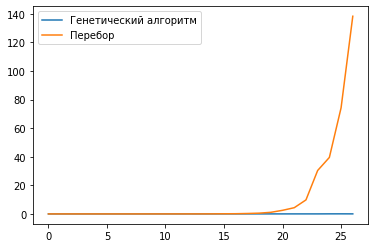

In [25]:
plt.plot(time_evolution, label = "Генетический алгоритм")
plt.plot(time_bruteforce, label = "Перебор")
plt.legend()
plt.show()

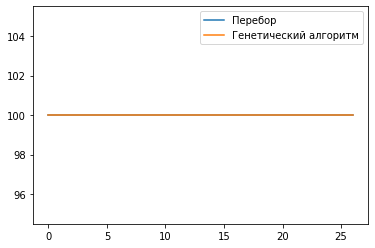

In [26]:
plt.plot(accuracy_bruteforce, label = "Перебор")
plt.plot(accuracy_evolution, label = "Генетический алгоритм")
plt.legend()
plt.show()

Рассмотрим, как меняется качество и время выполнения генетического алгоритма в зависимости от размера популяций

In [28]:
# Размер популяции - 5

full_weight_evolution = 0;
accuracy_evolution_5 = []
time_evolution_5 = []

for i in range(1, 100):
    full_weight_evolution += i
    things = []
    for j in range(1, i + 1):
        things += [Thing(j, j, j)]
    
    start = time.time()
    res_2, gen_2 = run_evolution(
        population_func=partial(
            generate_population, size=5, genome_length=len(things)
        ),
            fitness_func=partial(
            fitness, things=things, weight_limit=3000
        ),
        fitness_limit=full_weight_evolution,
        generation_limit=100
    )
    end = time.time()
    
    things_list = genome_to_list(res_2[0], things)
    
    accuracy_evolution_5 += [int(len(things_list) / i * 100)]
    time_evolution_5 += [end - start]

In [29]:
# Размер популяции - 15

full_weight_evolution = 0;
accuracy_evolution_15 = []
time_evolution_15 = []

for i in range(1, 100):
    full_weight_evolution += i
    things = []
    for j in range(1, i + 1):
        things += [Thing(j, j, j)]
    
    start = time.time()
    res_2, gen_2 = run_evolution(
        population_func=partial(
            generate_population, size=15, genome_length=len(things)
        ),
            fitness_func=partial(
            fitness, things=things, weight_limit=3000
        ),
        fitness_limit=full_weight_evolution,
        generation_limit=100
    )
    end = time.time()
    
    things_list = genome_to_list(res_2[0], things)
    
    accuracy_evolution_15 += [int(len(things_list) / i * 100)]
    time_evolution_15 += [end - start]

In [30]:
# Размер популяции - 30

full_weight_evolution = 0;
accuracy_evolution_30 = []
time_evolution_30 = []

for i in range(1, 100):
    full_weight_evolution += i
    things = []
    for j in range(1, i + 1):
        things += [Thing(j, j, j)]
    
    start = time.time()
    res_2, gen_2 = run_evolution(
        population_func=partial(
            generate_population, size=30, genome_length=len(things)
        ),
            fitness_func=partial(
            fitness, things=things, weight_limit=3000
        ),
        fitness_limit=full_weight_evolution,
        generation_limit=100
    )
    end = time.time()
    
    things_list = genome_to_list(res_2[0], things)
    
    accuracy_evolution_30 += [int(len(things_list) / i * 100)]
    time_evolution_30 += [end - start]

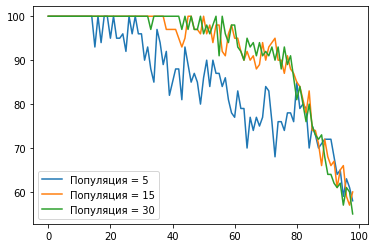

In [31]:
plt.plot(accuracy_evolution_5, label = "Популяция = 5")
plt.plot(accuracy_evolution_15, label = "Популяция = 15")
plt.plot(accuracy_evolution_30, label = "Популяция = 30")
plt.legend()
plt.show()

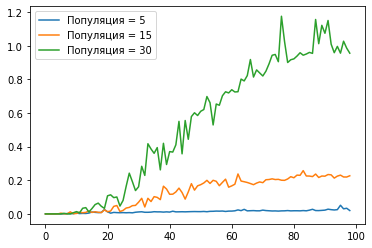

In [32]:
plt.plot(time_evolution_5, label = "Популяция = 5")
plt.plot(time_evolution_15, label = "Популяция = 15")
plt.plot(time_evolution_30, label = "Популяция = 30")
plt.legend()
plt.show()

#### Вывод
По графикам видно, что алгорит имеет свой предел качества. При увеличении размера популяции сначала качество растет, а с какого-то момента (размера популяции равного 15) качество не сильно изменяется. Однако, при этом время выполнения алгоритма при увеличении размера популяции значительно возрастает.

### Часть 4. Применение генетического алгоритма в реальной задаче

Составление оптимальной диеты на основе данных с kaggle. Баланс основных элементов в основном меню.

In [167]:
import os
import pandas as pd
import numpy as np

In [168]:
# Загружаем датасет с блюдами

food_table = pd.read_csv('epi_r.csv')

In [173]:
food_table

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,Parmesan Puffs,3.125,28.0,2.0,2.0,64.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,Artichoke and Parmesan Risotto,4.375,671.0,22.0,28.0,583.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,Turkey Cream Puff Pie,4.375,563.0,31.0,38.0,652.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20050,Snapper on Angel Hair with Citrus Cream,4.375,631.0,45.0,24.0,517.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
# Выводим колонны, чтоб понять, какие нам нужны

food_table.columns

Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yellow squash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snack week', 'turkey'],
      dtype='object', length=680)

In [209]:
# Создаем новый датасет с нужными данными. Будем просчитывать меню по калориям, жирам и белкам

table = food_table[['title','calories','protein','fat']].copy().dropna()
table.head()

,title,calories,protein,fat
0,"Lentil, Apple, and Turkey Wrap",426.0,30.0,7.0
1,Boudin Blanc Terrine with Red Onion Confit,403.0,18.0,23.0
2,Potato and Fennel Soup Hodge,165.0,6.0,7.0
4,Spinach Noodle Casserole,547.0,20.0,32.0
5,The Best Blts,948.0,19.0,79.0


In [210]:
table.size

63464

In [211]:
# Для простоты вызуализации немного обрежем данные

table = table[:1000]
table.size

4000

In [212]:
# Задаем средние значения

av_calories = 1800
av_protein = 50
av_fat = 50

In [213]:
Genome = List[int] # Геном - закодированное представление рюкзака
Population = List[Genome] # Популяция - набор геномов
FitnessFunc = Callable[[Genome], int] # Проверка полученного решения
PopulateFunc = Callable[[], Population] # Генерация популяции. Шаг инициализации
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome, Genome]] # Функция селекции
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]] # Функция скрещивания
MutationFunc = Callable[[Genome], Genome] # Функция мутации

# Объект продукта, с которым будем работать

Plate = namedtuple('Plate', ['title', 'protein', 'fat', 'calories'])

In [214]:
import math

In [215]:
# Генерация генома определенной длины

def generate_genome(length: int) -> Genome:
    return [0] * length

In [216]:
# Проверка ценности меню. Проверка полученного решения

def fitness(genome: Genome, plates: [Plate], calories_limit: int) -> int:
    if len(genome) != len(plates):
        raise ValueError("Геном и список вещей должны быть одной длины")
        
    calories = 0
    protein = 0
    fat = 0
    
    for i, plate in enumerate(plates):
        if genome[i] == 1:
            calories += plate.calories
            protein += plate.protein
            fat += plate.fat
            
            if calories > calories_limit:
                return 10000
    return math.sqrt((av_protein - protein)**2 + (av_fat - fat)**2)

In [241]:
# Меняем немного метод, чтоб лучшее решение вычислялось по уменьшению ошибки

def run_evolution(
    population_func: PopulateFunc,
    fitness_func: FitnessFunc,
    fitness_limit: int,
    selection_func: SelectionFunc = selection_pair, 
    crossover_func: CrossoverFunc = single_point_crossover,
    mutation_func: MutationFunc = mutation,
    generation_limit: int = 100
) -> Tuple[Population, int]:
    # Инициализация
    population = population_func()
    
    # Повторяется до ограничения на количество поколений
    for i in range(generation_limit):
        # Сортируется, чтоб лучшие популции были в начале
        population = sorted(population, key=lambda genome: fitness_func(genome), reverse=False)
                
        # Если качество популяции лучше, чем заданное, то алгоритм завершается
        if fitness_func(population[0]) <= fitness_limit:
            return population, i

        # В новое поколение передаем две лучшие популции
        next_generation = population[0:2]

        for j in range(int(len(population) / 2) - 1):
            parents = selection_func(population, fitness_func)
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            offspring_a = mutation_func(offspring_a, probability=0.3)
            offspring_b = mutation_func(offspring_b, probability=0.5)
            next_generation += [offspring_a, offspring_b]

        population = next_generation

    return population, i

In [242]:
# Утилиты для вывода результата

def to_string(things: [Plate]):
    return f"[{', '.join([t.title for t in things])}]"

def fats(things: [Plate]):
    return sum([t.fat for t in things])

def protein(things: [Plate]):
    return sum([t.protein for t in things])


def colories(things: [Plate]):
    return sum([p.calories for p in things])


def print_stats(things: [Plate]):
    print(f"Лучший результат: {to_string(things)}")
    print(f"Калории: {colories(things)}")
    print(f"Белок: {protein(things)}")
    print(f"Жиры: {fats(things)}")

def genome_to_list(genome: Genome, things: [Plate]) -> [Plate]:
    result = []
    for i, thing in enumerate(things):
        if genome[i] == 1:
            result += [thing]
    
    return result

In [243]:
# Преобразуем датасет в список объектов

plates = []

for value in table.values.tolist():
    plates += [Plate(value[0], value[2], value[3], value[1])]
    
plates[0]

Plate(title='Lentil, Apple, and Turkey Wrap ', protein=30.0, fat=7.0, calories=426.0)

In [252]:
population, generations = run_evolution(
    population_func=partial(
        generate_population, size=15, genome_length=len(plates)
    ),
    fitness_func=partial(
        fitness, plates=plates, calories_limit=av_calories
    ),
    fitness_limit=5,
    generation_limit=1000
)

In [253]:
results = genome_to_list(population[0], plates)

print(f"Количетсво поколений: {generations}")
print_stats(results)

Количетсво поколений: 5
Лучший результат: [Broccoli Rabe and Butternut Squash , Pavlova Pyatt , Beef Bone Broth , Chocolate Yogurt Cake ]
Калории: 1228.0
Белок: 46.0
Жиры: 49.0


### Выводы
Таким образом, данный алгоритм хорошо себя показывает как на учебных, так и на реальных задачах. Работая достаточно качественно и быстро, мы способны достичь определенного приближения к нашему значению качества. 